In [1]:
import numpy as np
from datasets.graph import load_graph
from matplotlib import pyplot as plt

In [2]:
# This function opens a preprocessed graph and grabs all the phi_slope, z0 and truth info
def get_z0_phi_slope(fname):
    g = load_graph(fname)

    n_nodes = g.Ro[2]
    n_edges = g.Ro[3]
    X = g.X
    y = g.y
    Ro_flat = g.Ro[0][0][np.argsort(g.Ro[0][1])]           
    Ri_flat = g.Ri[0][0][np.argsort(g.Ri[0][1])]                       


    R_coordinate = np.zeros(n_nodes)
    R_coordinate[:] = 1000*X[:,0]

    Z_coordinate = np.zeros(n_nodes)
    Z_coordinate[:] = 1000*X[:,2]

    Phi_coordinate = np.zeros(n_nodes)
    Phi_coordinate[:] = np.pi*X[:,1]

    delta_R   = np.zeros(n_edges)
    delta_phi = np.zeros(n_edges)
    delta_Z = np.zeros(n_edges)
    Z0      = np.zeros(n_edges)

    for i in range(n_edges):
        delta_R[i] = R_coordinate[Ri_flat[i]] - R_coordinate[Ro_flat[i]]
        delta_Z[i] = Z_coordinate[Ri_flat[i]] - Z_coordinate[Ro_flat[i]]
        Z0[i]      = Z_coordinate[Ri_flat[i]] - R_coordinate[Ri_flat[i]] * delta_Z[i] / delta_R[i]
        delta_phi[i] = abs(Phi_coordinate[Ri_flat[i]] - Phi_coordinate[Ro_flat[i]])
        if delta_phi[i] > np.pi:
            delta_phi[i] = abs(delta_phi[i] - 2*np.pi)

    phi_slope = abs(delta_phi/delta_R)
#     phi_slope_true  = phi_slope[y > 0]
#     Z0_true  = abs(Z0[y > 0])
           
    return abs(Z0), phi_slope, y

In [3]:
# Loop over all the events and concatanate all the vectors into one large one
N_events = 100

for i in range(N_events):
    event_num = 1000 + i 
    fname = '/data/gnn_code/heptrkx-gnn-tracking/output/event00000' + str(event_num) + '_g000.npz'

    file_results = get_z0_phi_slope(fname)
    if i == 0:
        z0        = file_results[0]
        phi_slope = file_results[1]
        y         = file_results[2]
        
    else:
        z0        = np.append(z0,        file_results[0])
        phi_slope = np.append(phi_slope, file_results[1])
        y         = np.append(y,         file_results[2])

Text(0, 0.5, 'phi slope')

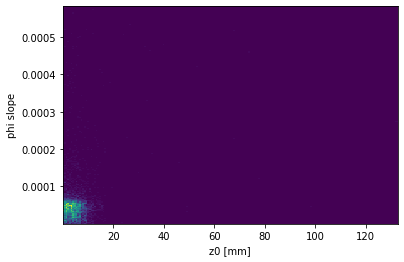

In [4]:
# Plot the truth distibutions
plt.hist2d(z0[y > 0], phi_slope[y > 0], 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

Text(0, 0.5, 'phi slope')

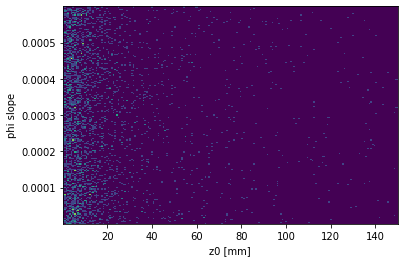

In [5]:
# Plot the truth distibutions
plt.hist2d(z0[y < 1], phi_slope[y < 1], 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

In [6]:
# Find the optimal z0 cut value for a given truth efficiency threshold
z0_true = z0[y > 0]
N_edges_true = len(z0_true)
threshold = .97
fraction = 0
cut = 0
while (fraction < threshold):
    cut += .001
    z0_cut_opt = z0_true[z0_true < cut]
    fraction = len(z0_cut_opt)/N_edges_true
print(cut, fraction)
z0_value = cut

11.577999999999022 0.9700118764845606


In [7]:
# Find the optimal phi slope cut value for a given truth efficiency threshold
phi_slope_true = phi_slope[y > 0]
N_edges_true = len(phi_slope_true)
threshold = .97
fraction = 0
cut = 0
while (fraction < threshold):
    cut += .0000001
    phi_cut_opt = phi_slope_true[phi_slope_true < cut]
    fraction = len(phi_cut_opt)/N_edges_true
print(cut, fraction)
phi_value = cut

0.0001460000000000027 0.9701603325415677


In [8]:
# Calculate the combined truth efficiency
# Want this value close to 1
z0_z0cut        = z0_true       [z0_true < z0_value]
phi_slope_z0cut = phi_slope_true[z0_true < z0_value]
N_edges_cut1 = len(z0_z0cut)
print('Using cut z0 < ' + str(z0_value))
# print('Remaining Fraction = ' + str(N_edges_cut1/N_edges_true))

z0_cut        = z0_z0cut       [phi_slope_z0cut < phi_value]
phi_slope_cut = phi_slope_z0cut[phi_slope_z0cut < phi_value]
N_edges_cut2 = len(z0_cut)
print('Using cut phi slope < ' + str(phi_value))
print('Truth Efficiency = ' + str(N_edges_cut2/N_edges_true))

Using cut z0 < 11.577999999999022
Using cut phi slope < 0.0001460000000000027
Truth Efficiency = 0.9456650831353919


Text(0, 0.5, 'phi slope')

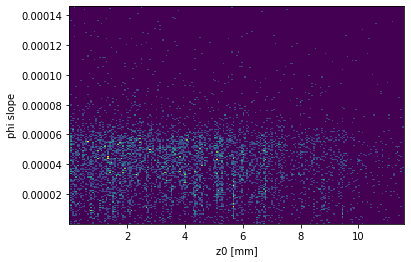

In [9]:
# Plot after cuts
plt.hist2d(z0_cut, phi_slope_cut, 200)
plt.xlabel("z0 [mm]")
plt.ylabel("phi slope")

In [10]:
# Calculate the truth edge purity
# Want this value close to .5

print("Initial Purity = " + str(len(y[y > 0])/len(y)))
y_cut = y[phi_slope < phi_value]
print("Purity after phi slope cut = " + str(len(y_cut[y_cut > 0])/len(y_cut)))
y_cut = y[z0 < z0_value]
print("Purity after z0 cut  = " + str(len(y_cut[y_cut > 0])/len(y_cut)))


y_cut   = y[phi_slope < phi_value]
z0_cut  = z0[phi_slope < phi_value]
phi_cut = phi_slope[phi_slope < phi_value]
y_cut2  = y_cut[z0_cut < z0_value]

print("Final Purity = " + str(len(y_cut2[y_cut2 > 0])/len(y_cut2)))

Initial Purity = 0.6695825049701789
Purity after phi slope cut = 0.878596396880882
Purity after z0 cut  = 0.7817659727207465
Final Purity = 0.9274898078043099


In [11]:
# Find the optimal z0 cut value for a given truth efficiency threshold
# y_cut   = y[phi_slope < phi_value]
# z0_cut  = z0[phi_slope < phi_value]

# print(len(z0_cut[y_cut > 0]) / len(z0_cut))

# threshold = .5
# fraction = 1
# cut = 0
# while (fraction > threshold):
#     cut += 1
#     y_cut_opt  = y_cut[z0_cut < cut]
#     z0_cut_opt = z0_cut[z0_cut < cut]
#     fraction = len(z0_cut_opt[y_cut_opt > 0]) / len(z0_cut_opt)
#     print(cut, fraction)
# z0_value = cut